In [1]:
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('seaborn-dark')
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', None)
import matplotlib as plt
plt.rc('font', size=14)

def plot_2d_separator(classifier, X, fill=False, line=True, ax=None, eps=None):
    if eps is None:
        
        eps = 1.0
    x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
    y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
    xx = np.linspace(x_min, x_max, 100)
    yy = np.linspace(y_min, y_max, 100)
    
    X1, X2 = np.meshgrid(xx, yy)
    X_grid = np.c_[X1.ravel(), X2.ravel()]
    try:
        decision_values = classifier.decision_function(X_grid)
        levels = [0]
        fill_levels = [decision_values.min(), 0, decision_values.max()]
    except:
        decision_values = classifier.predict_proba(X_grid)[:, 1]
        levels = [.5]
        fill_levels = [0, .5, 1]
        
    if ax is None:
        ax = plt.gca()
    if fill:
        ax.contourf(X1, X2, decision_values.reshape(X1.shape),
                    levels=fill_levels, colors=['cyan', 'pink'])
    if line:
        ax.contour(X1, X2, decision_values.reshape(X1.shape), levels=levels,
                   colors="black")
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())

## Загружаем данные

train = pd.read_csv('/home/paniquex/PycharmProjects/IML_homeworks/credit_scoring/train.csv')
test = pd.read_csv('/home/paniquex/PycharmProjects/IML_homeworks/credit_scoring/test.csv')
print(train['плохой_клиент'][train['семья'].isna()].value_counts())
print(train['плохой_клиент'].value_counts())
print(train.shape, test.shape)

y = train.pop('плохой_клиент')
train.shape, y.shape

## Предобработка

## Очень много пропусков в доходе: 

print(train.columns)
print(train.info())

print(test.info())

## Интересный человек №21595

#train.sort_values(by='недвижимость', ascending=False).head()

train.describe()

#train['доход'][train["доход"] < 1].value_counts()

## Заполним пропуски в доходе средним значением по всей таблице, а значение семьи = 0 

#train.sort_values(by='доход', ascending=False).head(10)

mean_income_train = train['доход'].mean()
mean_income_test = test['доход'].mean()
print(mean_income_train, mean_income_test)
#train['доход'].fillna(mean_income_train, inplace=True)
#test['доход'].fillna(mean_income_test, inplace=True)

### Семья

#train['семья'].fillna(1, inplace=True)
#test['семья'].fillna(1, inplace=True)

0    2815
1     136
Name: плохой_клиент, dtype: int64
0    104956
1      7544
Name: плохой_клиент, dtype: int64
(112500, 11) (37500, 10)
Index(['линии', 'возраст', 'поведение_30-59_дней', 'Debt_Ratio', 'доход',
       'число_кредитов', 'поведение_90_дней', 'недвижимость',
       'поведение_60-89_дней', 'семья'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112500 entries, 0 to 112499
Data columns (total 10 columns):
линии                   112500 non-null float64
возраст                 112500 non-null int64
поведение_30-59_дней    112500 non-null int64
Debt_Ratio              112500 non-null float64
доход                   90274 non-null float64
число_кредитов          112500 non-null int64
поведение_90_дней       112500 non-null int64
недвижимость            112500 non-null int64
поведение_60-89_дней    112500 non-null int64
семья                   109549 non-null float64
dtypes: float64(4), int64(6)
memory usage: 8.6 MB
None
<class 'pandas.core.frame.DataF

In [2]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict

class DjStacking(BaseEstimator, ClassifierMixin):  
    """Стэкинг моделей scikit-learn"""

    def __init__(self, models, ens_model):
        """
        Инициализация
        models - базовые модели для стекинга
        ens_model - мета-модель
        """
        self.models = models
        self.ens_model = ens_model
        self.n = len(models)
        self.valid = None
        
    def fit(self, X, y=None, p=0.25, cv=3, err=0.001, random_state=None):
        """
        Обучение стекинга
        p - в каком отношении делить на обучение / тест
            если p = 0 - используем всё обучение!
        cv  (при p=0) - сколько фолдов использовать
        err (при p=0) - величина случайной добавки к метапризнакам
        random_state - инициализация генератора
            
        """
        if (p > 0): # делим на обучение и тест
            # разбиение на обучение моделей и метамодели
            train, valid, y_train, y_valid = train_test_split(X, y, test_size=p, random_state=random_state)
            
            # заполнение матрицы для обучения метамодели
            self.valid = np.zeros((valid.shape[0], self.n))
            for t, clf in enumerate(self.models):
                clf.fit(train, y_train)
                self.valid[:, t] = clf.predict(valid)
                
            # обучение метамодели
            self.ens_model.fit(self.valid, y_valid)
            
        else: # используем всё обучение
            
            # для регуляризации - берём случайные добавки
            self.valid = err*np.random.randn(X.shape[0], self.n)
            
            for t, clf in enumerate(self.models):
                # это oob-ответы алгоритмов
                self.valid[:, t] += cross_val_predict(clf, X, y, cv=cv, n_jobs=-1, method='predict')
                # но сам алгоритм надо настроить
                clf.fit(X, y)
            
            # обучение метамодели
            self.ens_model.fit(self.valid, y)  
            

        return self
    


    def predict(self, X, y=None):
        """
        Работа стэкинга
        """
        # заполение матрицы для мета-классификатора
        X_meta = np.zeros((X.shape[0], self.n))
        
        for t, clf in enumerate(self.models):
            X_meta[:, t] = clf.predict(X)
        
        a = self.ens_model.predict(X_meta)
        
        return (a)

In [3]:
print(train.shape, test.shape)

(112500, 10) (37500, 10)


In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
strCV = StratifiedKFold(n_splits = 5, random_state = 10)
model_rand_forest_line = RandomForestClassifier(n_estimators = 40)
rand_forest_line_grid_param = {'max_depth' : range(8, 14), 'max_features' : range(3, 9), 
                               'criterion' : ['entropy'], 
                              'min_samples_split': [30],
                              'min_samples_leaf' : [30],
                               'min_impurity_decrease' : [0.00001, 0.0004, 0.1],
                                'min_weight_fraction_leaf' : [0.00005, 0.0001, 0.01],
                                 'min_impurity_split' : [0.00004, 0.1, 0.001, 1, 0.0001]
                              }
                                            
model_rand_forest_line_grid = GridSearchCV(estimator=model_rand_forest_line, param_grid=rand_forest_line_grid_param, cv=strCV, verbose=1, n_jobs=-1)
#model_rand_forest_line_grid.fit(train, y)

In [5]:
# model_rand_forest_line_grid.best_params_
# {'criterion': 'entropy',
#  'max_depth': 8,
#  'max_features': 5,
#  'min_impurity_decrease': 1e-05,
#  'min_impurity_split': 0.001,
#  'min_samples_leaf': 30,
#  'min_samples_split': 30,
#  'min_weight_fraction_leaf': 0.0001}

X_train, X_test, y_train, y_test = train_test_split(train, y, test_size = 0.8, random_state = 20)

model_rand_forest_new = RandomForestClassifier(n_estimators=250, criterion= 'entropy', min_impurity_decrease=1e-05,
 min_weight_fraction_leaf = 0.0001,
 min_impurity_split = 0.001,
 max_depth= 8,
 max_features= 5,
 class_weight = {1 : 1, 0 : 3},
 min_samples_leaf= 30,
 min_samples_split= 30,
 oob_score= False,
 random_state = 20)
model_rand_forest_new.fit(X_train, y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

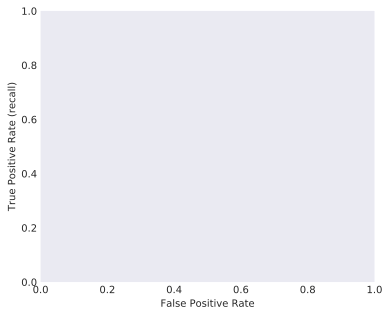

In [6]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import warnings
warnings.simplefilter('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg' 
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5
plt.figure(figsize=(6,5))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (recall)")
fpr9, tpr9, _= roc_curve(y_test, model_rand_forest_new.predict_proba(X_test)[:, 1] )
auc9 = roc_auc_score(y_test, model_rand_forest_new.predict_proba(X_test)[:, 1])
plt.plot(fpr9, tpr9, label=("auc=%.4f" % auc9), linewidth=2,
color='#990000')
plt.legend(loc="best")


In [38]:

model_rand_forest = RandomForestClassifier(n_estimators=150, criterion= 'entropy', min_impurity_decrease=0.00001,
 min_weight_fraction_leaf = 0.00005,
 min_impurity_split = 0.00004,
 max_depth= 9,
 max_features= 4,
 class_weight = {1:4, 0:1},
 min_samples_leaf= 30,
 min_samples_split= 30,
 oob_score= False,
 random_state = 20)

train_with_new_features =  train.copy()
train_log_reg_data = train_with_new_features.copy()
##большие значения у линий - выбросы, уберем их



train_log_reg_data['линии'][train_log_reg_data['линии'] >= 10] = 1
feature_1 = (train_log_reg_data['поведение_30-59_дней'] >= 1) #| (train_log_reg_data['поведение_60-89_дней'] >= 1) \
#             | (train_log_reg_data['поведение_90_дней'] >= 1)
train_log_reg_data['feature_1'] = feature_1
train_log_reg_data['поведение_90_дней'][train_log_reg_data['поведение_90_дней'] > 35] = 1
train_log_reg_data['поведение_60-89_дней'][train_log_reg_data['поведение_60-89_дней'] > 35] = 1
train_log_reg_data['поведение_30-59_дней'][train_log_reg_data['поведение_30-59_дней'] > 35] = 1
# 
# 
# 
# 
feature_2 = (train_log_reg_data['недвижимость'] >= 1) 
train_log_reg_data['feature_2'] = feature_2

feature_3 = (train_log_reg_data['число_кредитов'] >= 15)
train_log_reg_data['feature_3'] = feature_3
# 
feature_4 = (train_log_reg_data['доход'] <= train_log_reg_data['доход'].quantile(q=0.35))
train_log_reg_data['feature_4'] = feature_4

feature_5 = (train_log_reg_data['Debt_Ratio'] <= train_log_reg_data['Debt_Ratio'].mean()))
train_log_reg_data['feature_5'] = feature_5

feature_6 = (train_log_reg_data['линии'] <= train_log_reg_data['линии'].quantile(q=0.05))
train_log_reg_data['feature_6'] = feature_6

feature_7 = (train_log_reg_data['поведение_60-89_дней'] >= 1)
train_log_reg_data['feature_7'] = feature_7

feature_8 = (train_log_reg_data['поведение_90_дней'] >= 1)
train_log_reg_data['feature_8'] = feature_8

feature_9 = (train_log_reg_data['возраст'] >= train_log_reg_data['возраст'].quantile(q=0.6))
train_log_reg_data['feature_9'] = feature_9

feature_10 = (3*train_log_reg_data['поведение_60-89_дней'] + train_log_reg_data['поведение_30-59_дней']) > train_log_reg_data['поведение_90_дней']
train_log_reg_data['feature_10'] = feature_10

from sklearn.preprocessing import StandardScaler
#col_names = ['линии', 'доход', 'Debt_Ratio']
#features = train_log_reg_data[col_names]
#features = StandardScaler().fit_transform(features)
#train_log_reg_data[col_names] = features


X_train, X_test, y_train, y_test = train_test_split(train_log_reg_data, y, train_size = 0.2, random_state=20)

from sklearn.ensemble import GradientBoostingClassifier
passiveAggre = GradientBoostingClassifier(loss='exponential',learning_rate=0.1,  min_impurity_decrease=0.00001,
 min_weight_fraction_leaf = 0.00005,
 min_impurity_split = 0.00004,
 max_depth= 4,
 max_features= 4,
 min_samples_leaf= 30,
 min_samples_split= 3,
 random_state = 20)
rand_forest_line_grid_param = {'max_depth' : range(2, 7), 'max_features' : range(3, 7),
                               'learning_rate' : [1, 0.1, 0.01],
                               'loss' : ['exponential', 'deviance'], 
                              'min_samples_split': [30],
                              'min_samples_leaf' : [30],
                               'min_impurity_decrease' : [0.00001, 0.1],
                                'min_weight_fraction_leaf' : [0.00005, 0.01],
                                 'min_impurity_split' : [0.00004, 0.001, 1, 0.0001]
                              }
strCV = StratifiedKFold(n_splits = 4, random_state = 10)                                            
#model_boosting_forest_line_grid = GridSearchCV(estimator=passiveAggre, param_grid=rand_forest_line_grid_param, cv=strCV, verbose=1, n_jobs=-1)
#model_boosting_forest_line_grid.fit(train_log_reg_data, y)

#model_rand_forest.fit(X_train, y_train)


IndentationError: unindent does not match any outer indentation level (<tokenize>, line 78)

In [39]:
model_boosting_forest_line_grid.best_params_
{'learning_rate': 0.1,
 'loss': 'exponential',
 'max_depth': 5,
 'max_features': 4,
 'min_impurity_decrease': 0.1,
 'min_impurity_split': 4e-05,
 'min_samples_leaf': 30,
 'min_samples_split': 30,
 'min_weight_fraction_leaf': 5e-05}

NameError: name 'model_boosting_forest_line_grid' is not defined

In [41]:
train_with_new_features =  train.copy()
train_log_reg_data = train_with_new_features.copy()

test_log_reg_data = test.copy()

cols_with_missing_data = (col for col in train_log_reg_data.columns if train_log_reg_data[col].isnull().any())
for col in cols_with_missing_data:
    train_log_reg_data[col + '_isMissed'] = train_log_reg_data[col].isnull()
    test_log_reg_data[col + '_isMissed'] = test_log_reg_data[col].isnull()
    
mean_income_train = train_log_reg_data['доход'].mean()
mean_income_test = test_log_reg_data['доход'].mean()
print(mean_income_train, mean_income_test)
train_log_reg_data['доход'].fillna(mean_income_train, inplace=True)
test_log_reg_data['доход'].fillna(mean_income_test, inplace=True)

### Семья

train_log_reg_data['семья'].fillna(0, inplace=True)
test_log_reg_data['семья'].fillna(0, inplace=True)
    
##большие значения у линий - выбросы, уберем их


train_log_reg_data['Debt_Ratio'][train_log_reg_data['Debt_Ratio'] >= train_log_reg_data['Debt_Ratio'].quantile(q=0.995)] = train_log_reg_data['Debt_Ratio'].mean()
train_log_reg_data['Debt_Ratio'][train_log_reg_data['Debt_Ratio'] <= train_log_reg_data['Debt_Ratio'].quantile(q=0.005)] = train_log_reg_data['Debt_Ratio'].mean()
train_log_reg_data['доход'][train_log_reg_data['доход'] >= train_log_reg_data['доход'].quantile(q=0.995)] = train_log_reg_data['доход'].mean()
train_log_reg_data['линии'][(train_log_reg_data['линии'] >= 11)] = 0.3
train_log_reg_data['доход'][train_log_reg_data['доход'] > train_log_reg_data['доход'].quantile(q=0.85)] = train_log_reg_data['доход'].quantile(q=0.4)
train_log_reg_data['Debt_Ratio'][train_log_reg_data['Debt_Ratio'] > train_log_reg_data['Debt_Ratio'].quantile(q=0.8)] = train_log_reg_data['Debt_Ratio'].quantile(q=0.4)

feature_1 = (train_log_reg_data['поведение_30-59_дней'] >= 1) #| (train_log_reg_data['поведение_60-89_дней'] >= 1) \
            # | (train_log_reg_data['поведение_90_дней'] >= 1)
train_log_reg_data['feature_1'] = feature_1
train_log_reg_data['поведение_90_дней'][train_log_reg_data['поведение_90_дней'] > 35] = 1
train_log_reg_data['поведение_60-89_дней'][train_log_reg_data['поведение_60-89_дней'] > 35] = 1
train_log_reg_data['поведение_30-59_дней'][train_log_reg_data['поведение_30-59_дней'] > 35] = 1




feature_2 = (train_log_reg_data['недвижимость'] >= 1) 
train_log_reg_data['feature_2'] = feature_2

feature_3 = (train_log_reg_data['число_кредитов'] >= 15)
train_log_reg_data['feature_3'] = feature_3

feature_4 = (train_log_reg_data['доход'] <= train_log_reg_data['доход'].quantile(q=0.35))
train_log_reg_data['feature_4'] = feature_4

feature_5 = (train_log_reg_data['Debt_Ratio'] <= train_log_reg_data['Debt_Ratio'].mean())
train_log_reg_data['feature_5'] = feature_5

feature_6 = (train_log_reg_data['линии'] <= train_log_reg_data['линии'].quantile(q=0.05))
train_log_reg_data['feature_6'] = feature_6

feature_7 = (train_log_reg_data['поведение_60-89_дней'] >= 1)
train_log_reg_data['feature_7'] = feature_7

feature_8 = (train_log_reg_data['поведение_90_дней'] >= 1)
train_log_reg_data['feature_8'] = feature_8

feature_9 = (train_log_reg_data['возраст'] >= train_log_reg_data['возраст'].quantile(q=0.6))
train_log_reg_data['feature_9'] = feature_9

feature_10 = (3*train_log_reg_data['поведение_60-89_дней'] + 5 * train_log_reg_data['поведение_30-59_дней']) > train_log_reg_data['поведение_90_дней']
train_log_reg_data['feature_10'] = feature_10

feature_11 = np.log2(train_log_reg_data['линии']+ 0.00001)
train_log_reg_data['feature_11'] = feature_11


test_log_reg_data['Debt_Ratio'][test_log_reg_data['Debt_Ratio'] >= test_log_reg_data['Debt_Ratio'].quantile(q=0.995)] = test_log_reg_data['Debt_Ratio'].mean()
test_log_reg_data['Debt_Ratio'][test_log_reg_data['Debt_Ratio'] <= test_log_reg_data['Debt_Ratio'].quantile(q=0.005)] = test_log_reg_data['Debt_Ratio'].mean()
test_log_reg_data['доход'][test_log_reg_data['доход'] >= test_log_reg_data['доход'].quantile(q=0.995)] = test_log_reg_data['доход'].mean()
test_log_reg_data['линии'][(test_log_reg_data['линии'] >= 11)] = 0.3
test_log_reg_data['доход'][test_log_reg_data['доход'] > test_log_reg_data['доход'].quantile(q=0.85)] = test_log_reg_data['доход'].quantile(q=0.4)
test_log_reg_data['Debt_Ratio'][test_log_reg_data['Debt_Ratio'] > test_log_reg_data['Debt_Ratio'].quantile(q=0.8)] = test_log_reg_data['Debt_Ratio'].quantile(q=0.4)

feature_1 = (test_log_reg_data['поведение_30-59_дней'] >= 1) #| (test_log_reg_data['поведение_60-89_дней'] >= 1) \
            # | (test_log_reg_data['поведение_90_дней'] >= 1)
test_log_reg_data['feature_1'] = feature_1
test_log_reg_data['поведение_90_дней'][test_log_reg_data['поведение_90_дней'] > 35] = 1
test_log_reg_data['поведение_60-89_дней'][test_log_reg_data['поведение_60-89_дней'] > 35] = 1
test_log_reg_data['поведение_30-59_дней'][test_log_reg_data['поведение_30-59_дней'] > 35] = 1




feature_2 = (test_log_reg_data['недвижимость'] >= 1) 
test_log_reg_data['feature_2'] = feature_2

feature_3 = (test_log_reg_data['число_кредитов'] >= 15)
test_log_reg_data['feature_3'] = feature_3

feature_4 = (test_log_reg_data['доход'] <= test_log_reg_data['доход'].quantile(q=0.35))
test_log_reg_data['feature_4'] = feature_4

feature_5 = (test_log_reg_data['Debt_Ratio'] <= test_log_reg_data['Debt_Ratio'].mean())
test_log_reg_data['feature_5'] = feature_5

feature_6 = (test_log_reg_data['линии'] <= test_log_reg_data['линии'].quantile(q=0.05))
test_log_reg_data['feature_6'] = feature_6

feature_7 = (test_log_reg_data['поведение_60-89_дней'] >= 1)
test_log_reg_data['feature_7'] = feature_7

feature_8 = (test_log_reg_data['поведение_90_дней'] >= 1)
test_log_reg_data['feature_8'] = feature_8

feature_9 = (test_log_reg_data['возраст'] >= test_log_reg_data['возраст'].quantile(q=0.6))
test_log_reg_data['feature_9'] = feature_9

feature_10 = (3*test_log_reg_data['поведение_60-89_дней'] + 5 * test_log_reg_data['поведение_30-59_дней']) > test_log_reg_data['поведение_90_дней']
test_log_reg_data['feature_10'] = feature_10

feature_11 = np.log2(test_log_reg_data['линии']+ 0.00001)
test_log_reg_data['feature_11'] = feature_11



# 
# train_log_reg_data['линии'][train_log_reg_data['линии'] >= train_log_reg_data['линии'].quantile(q=0.995)] = train_log_reg_data['линии'].mean()
# train_log_reg_data['число_кредитов'][train_log_reg_data['число_кредитов'] >= train_log_reg_data['число_кредитов'].quantile(q=0.995)] = train_log_reg_data['число_кредитов'].mean()
# train_log_reg_data['поведение_30-59_дней'][train_log_reg_data['поведение_30-59_дней'] >= train_log_reg_data['поведение_30-59_дней'].quantile(q=0.995)] = train_log_reg_data['поведение_30-59_дней'].mean()
# train_log_reg_data['поведение_60-89_дней'][train_log_reg_data['поведение_60-89_дней'] >= train_log_reg_data['поведение_60-89_дней'].quantile(q=0.995)] = train_log_reg_data['поведение_60-89_дней'].mean()
# train_log_reg_data['поведение_90_дней'][train_log_reg_data['поведение_90_дней'] >= train_log_reg_data['поведение_90_дней'].quantile(q=0.995)] = train_log_reg_data['поведение_90_дней'].mean()










# train_log_reg_data['линии'][train_log_reg_data['линии'] >= 10] = 0
# feature_1 = (train_log_reg_data['поведение_30-59_дней'] >= 2) | (train_log_reg_data['поведение_60-89_дней'] >= 2) \
#               | (train_log_reg_data['поведение_90_дней'] >= 2)
# train_log_reg_data['feature_1'] = feature_1
# train_log_reg_data['поведение_90_дней'][train_log_reg_data['поведение_90_дней'] > 6] = -1
# train_log_reg_data['поведение_60-89_дней'][train_log_reg_data['поведение_60-89_дней'] > 5] = -1
# train_log_reg_data['поведение_30-59_дней'][train_log_reg_data['поведение_30-59_дней'] > 4] = -1
# from sklearn.preprocessing import StandardScaler
# col_names = ['доход']  #['поведение_90_дней', 'поведение_30-59_дней', 'поведение_60-89_дней']
# features = train_log_reg_data[col_names]
# features = StandardScaler().fit_transform(features)
# train_log_reg_data[col_names] = features
# from sklearn.linear_model import LogisticRegression
# 
rand_forest_line_grid_param = {'max_depth' : range(2, 7), 'max_features' : range(2, 7),
                               'learning_rate' : [1, 0.1, 0.01],
                               'loss' : ['exponential', 'deviance'], 
                                'subsample' : [0.3, 0.7, 0.8]
                              }

# train_log_reg_data.pop('поведение_30-59_дней')
# train_log_reg_data.pop('поведение_60-89_дней')
# train_log_reg_data.pop('поведение_90_дней')
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
X_train, X_test, y_train, y_test = train_test_split(train_log_reg_data, y, train_size = 0.8, random_state=20)

from sklearn.linear_model import LogisticRegression

assiveAggre_best = GradientBoostingClassifier(learning_rate=0.099,  min_impurity_decrease=0.00001, subsample=0.7, n_estimators=350,
min_weight_fraction_leaf = 0.00005,
min_impurity_split = 0.00004,
max_depth=4,
max_features=4,
min_samples_leaf= 160, #159
min_samples_split= 760, #760
random_state = 20)
assiveAggre_best1 = GradientBoostingClassifier(n_estimators=175, max_depth=5, max_features='auto', random_state=0, loss='exponential', subsample=0.75, learning_rate=0.1, criterion='mse')
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFECV
from sklearn.linear_model import RidgeClassifier
knn = RidgeClassifier()

#grid_boost = GridSearchCV(estimator=assiveAggre_best, param_grid=rand_forest_line_grid_param, cv=strCV, scoring='roc_auc', verbose=1)

degrees = [1, 4, 15]
#rfecv_boost = RFECV(estimator=assiveAggre_best, cv=StratifiedKFold(n_splits=4, random_state=20), step=2, scoring='roc_auc', verbose=1)
#polynomial_features = PolynomialFeatures(degree=2, interaction_only=True,
#                                             include_bias=False)
#pipeline = Pipeline([("polynomial_features", polynomial_features),
#                        ("rfecv_boost", rfecv_boost)])
#train_poly = train_log_reg_data.copy()
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
dec_tree = DecisionTreeClassifier(max_depth=9, max_features='auto', criterion='entropy', random_state=5)
from sklearn.neighbors import KNeighborsClassifier
rf1 = RandomForestClassifier(n_estimators=125, max_depth=11, max_features=2, random_state=4)
rf2 = RandomForestClassifier(n_estimators=100, max_depth=9, max_features=7, random_state=6)
rf3 = RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=10, random_state=0)


eclf = VotingClassifier(estimators=[('dt', assiveAggre_best), ('knn', assiveAggre_best1), ('rf1', rf1), ('rf2', rf2), ('rf3', rf3), ('logreg', rfecv)],
                        voting='soft', weights=[6, 3, 3, 3, 3, 2])




#pipeline.fit(X_train, y_train)
#rfecv_boost.fit(X_train, y_train)

6662.379910051621 6693.8207701283545


In [42]:
train_log_reg_data.head()

,линии,возраст,поведение_30-59_дней,Debt_Ratio,доход,число_кредитов,поведение_90_дней,недвижимость,поведение_60-89_дней,семья,доход_isMissed,семья_isMissed,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11
0,0.031258,57,0,0.397520,5000.00000,15,0,2,0,0.0,False,False,False,True,True,False,True,False,False,False,True,False,-4.999158
1,0.052332,64,0,0.308172,6662.37991,2,0,0,0,0.0,True,True,False,False,False,False,True,False,False,False,True,False,-4.255898
2,1.051793,40,1,0.308172,6662.37991,2,1,0,0,0.0,True,False,True,False,False,False,True,False,False,True,False,True,0.072864
3,0.981993,40,1,0.780109,6625.00000,8,0,1,0,4.0,False,False,True,True,False,False,True,False,False,False,False,True,-0.026201
4,0.163684,67,0,0.317596,4574.00000,5,0,2,0,0.0,False,False,False,True,False,True,True,False,False,False,True,False,-2.610928


In [43]:
#assiveAggre_best1.fit(X_train, y_train)
# assiveAggre_best1 = assiveAggre_best1.fit(X_train, y_train)

# model_rand_forest_new = model_rand_forest_new.fit(X_train, y_train) 
# model_rand_forest = model_rand_forest.fit(X_train, y_train)
#assiveAggre_best.fit(X_train, y_train)
eclf = eclf.fit(train_log_reg_data, y)

#grid_boost.fit(train, y)
#models = [assiveAggre_best, assiveAggre_best1]
#stacking1 = DjStacking(models, knn)
#stacking1.fit(X_train, y_train)

In [26]:
rcParams['figure.figsize'] = 8, 5
#plt.figure(figsize=(6,5))
#plt.xlabel("False Positive Rate")
#plt.ylabel("True Positive Rate (recall)")
#fpr9, tpr9, _= roc_curve(y, model_
#and_forest_new.predict_proba(train_log_reg_data)[:, 1] )
auc9 = roc_auc_score(y_test, eclf.predict_proba(X_test)[:, 1])
#plt.plot(fpr9, tpr9, label=("auc=%.4f" % auc9), linewidth=2,
#color='#990000') 

#plt.legend(loc="best")
print("auc=%.4f" % auc9)
#auc=0.8719 - on 80% train
#auc=0.8618 - on 20% train
#auc=0.8934 - on full train

NameError: name 'rcParams' is not defined

In [27]:
from sklearn.svm import SVC
svc = SVC(probability=True)


In [28]:
#svc.fit(X_train, y_train)

In [29]:
rcParams['figure.figsize'] = 8, 5
#plt.figure(figsize=(6,5))
#plt.xlabel("False Positive Rate")
#plt.ylabel("True Positive Rate (recall)")
#fpr9, tpr9, _= roc_curve(y, model_rand_forest_new.predict_proba(train_log_reg_data)[:, 1] )
auc9 = roc_auc_score(y_test, svc.predict_proba(X_test)[:, 1])
#plt.plot(fpr9, tpr9, label=("auc=%.4f" % auc9), linewidth=2,
#color='#990000')

#plt.legend(loc="best")
print("auc=%.4f" % auc9)

NameError: name 'rcParams' is not defined

In [30]:
rand_forest_line_grid_param_new = {'max_depth' : [9], 'max_features' : [3], 
                               'criterion' : ['entropy'], 
                              'min_samples_split': [35, 40, 100],
                              'min_samples_leaf' : [10],
                              'min_impurity_decrease' : [0, 0.01, 0.5, 1],
                              'min_weight_fraction_leaf' : [0., 0.000001, 0.00001, 0.5],
                              'n_estimators' : [50]}
                                            
model_rand_forest_line_grid_new = GridSearchCV(estimator=model_rand_forest_line, scoring='roc_auc', param_grid=rand_forest_line_grid_param_new, cv=strCV, verbose=1, n_jobs=-1)

NameError: name 'GridSearchCV' is not defined

In [31]:
model_rand_forest_line_grid_new.fit(X_train, y_train)

NameError: name 'model_rand_forest_line_grid_new' is not defined

In [32]:
model_rand_forest_line_grid_new.best_params_
{'criterion': 'entropy',
 'max_depth': 9,
 'max_features': 3,
 'min_impurity_decrease': 0,
 'min_samples_leaf': 20,
 'min_samples_split': 30,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 50}

NameError: name 'model_rand_forest_line_grid_new' is not defined

In [33]:
rcParams['figure.figsize'] = 8, 5
plt.figure(figsize=(6,5))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (recall)")
fpr9, tpr9, _= roc_curve(y_test, model_rand_forest_line_grid_new.predict_proba(X_test)[:, 1] )
auc9 = roc_auc_score(y_test, model_rand_forest_line_grid_new.predict_proba(X_test)[:, 1])
plt.plot(fpr9, tpr9, label=("auc=%.3f" % auc9), linewidth=2,
color='#990000')
plt.legend(loc="best")

NameError: name 'rcParams' is not defined

In [34]:
model_rand_forest_new = RandomForestClassifier(n_estimators=100, criterion= 'entropy',
 max_depth= 10,
 max_features= 10,
 min_samples_leaf= 20,
 min_samples_split= 30,
 oob_score= False,
 random_state = 20)


In [35]:
rcParams['figure.figsize'] = 8, 5
#plt.figure(figsize=(6,5))
#plt.xlabel("False Positive Rate")
#plt.ylabel("True Positive Rate (recall)")
#fpr9, tpr9, _= roc_curve(y, model_rand_forest_new.predict_proba(train_log_reg_data)[:, 1] )
auc9 = roc_auc_score(y_test, model_rand_forest_new.predict_proba(X_test)[:, 1])
#plt.plot(fpr9, tpr9, label=("auc=%.4f" % auc9), linewidth=2,
#color='#990000')
#plt.legend(loc="best")
print("auc=%.4f" % auc9)
#auc=0.8742

NameError: name 'rcParams' is not defined

## Предобработка данных для использования логистической регрессии

In [36]:
import numpy as np
train_log = train.copy()
test_log = test.copy()

from sklearn.preprocessing import StandardScaler
#col_names = ['линии', 'доход', 'Debt_Ratio']
#features = train_log[col_names]
#scaler = StandardScaler(with_mean = False, with_std = True).fit(features.values)
#features = scaler.transform(features.values)
#train_log[col_names] = features
#from sklearn.model_selection import train_test_split
#X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(train_log, y, train_size = 0.2)
train_log.describe()

,линии,возраст,поведение_30-59_дней,Debt_Ratio,доход,число_кредитов,поведение_90_дней,недвижимость,поведение_60-89_дней,семья
count,112500.000000,112500.000000,112500.000000,112500.000000,9.027400e+04,112500.000000,112500.000000,112500.000000,112500.000000,109549.000000
mean,6.057904,52.292702,0.425538,350.965444,6.662380e+03,8.464267,0.271627,1.019680,0.245333,0.755662
std,257.959993,14.765029,4.246085,1864.557746,1.540162e+04,5.149137,4.223498,1.130324,4.208686,1.113419
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.029840,41.000000,0.000000,0.175069,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.154015,52.000000,0.000000,0.366336,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.559389,63.000000,0.000000,0.863569,8.250000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,50708.000000,109.000000,98.000000,326442.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,13.000000


In [37]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
train_with_out_60_30 = train_log.copy()
train_with_out_60_30.pop('поведение_30-59_дней')
train_with_out_60_30.pop('поведение_60-89_дней')
log_reg_first = LogisticRegression()
rfecv = RFECV(estimator=log_reg_first, cv=5, scoring='accuracy', n_jobs=-1, step=1)
rfecv.fit(train, y)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [38]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=200, penalty='l2', C=0.01, random_state=20, class_weight=  'balanced', tol=0.00004, solver = 'sag')
train_with_new_features =  train.copy()
train_log_reg_data = train_with_new_features.copy()
##большие значения у линий - выбросы, уберем их



train_log_reg_data['линии'][(train_log_reg_data['линии'] >= 10)] = 0.3
train_log_reg_data['доход'][train_log_reg_data['доход'] > train_log_reg_data['доход'].quantile(q=0.85)] = train_log_reg_data['доход'].quantile(q=0.4)
train_log_reg_data['Debt_Ratio'][train_log_reg_data['Debt_Ratio'] > train_log_reg_data['Debt_Ratio'].quantile(q=0.8)] = train_log_reg_data['Debt_Ratio'].quantile(q=0.4)

feature_1 = (train_log_reg_data['поведение_30-59_дней'] >= 1) #| (train_log_reg_data['поведение_60-89_дней'] >= 1) \
            # | (train_log_reg_data['поведение_90_дней'] >= 1)
train_log_reg_data['feature_1'] = feature_1
train_log_reg_data['поведение_90_дней'][train_log_reg_data['поведение_90_дней'] > 35] = 1
train_log_reg_data['поведение_60-89_дней'][train_log_reg_data['поведение_60-89_дней'] > 35] = 1
train_log_reg_data['поведение_30-59_дней'][train_log_reg_data['поведение_30-59_дней'] > 35] = 1




feature_2 = (train_log_reg_data['недвижимость'] >= 1) 
train_log_reg_data['feature_2'] = feature_2

feature_3 = (train_log_reg_data['число_кредитов'] >= 15)
train_log_reg_data['feature_3'] = feature_3

feature_4 = (train_log_reg_data['доход'] <= train_log_reg_data['доход'].quantile(q=0.35))
train_log_reg_data['feature_4'] = feature_4

feature_5 = (train_log_reg_data['Debt_Ratio'] <= train_log_reg_data['Debt_Ratio'].mean()))
train_log_reg_data['feature_5'] = feature_5

feature_6 = (train_log_reg_data['линии'] <= train_log_reg_data['линии'].quantile(q=0.05))
train_log_reg_data['feature_6'] = feature_6

feature_7 = (train_log_reg_data['поведение_60-89_дней'] >= 1)
train_log_reg_data['feature_7'] = feature_7

feature_8 = (train_log_reg_data['поведение_90_дней'] >= 1)
train_log_reg_data['feature_8'] = feature_8

feature_9 = (train_log_reg_data['возраст'] >= train_log_reg_data['возраст'].quantile(q=0.6))
train_log_reg_data['feature_9'] = feature_9

feature_10 = (3*train_log_reg_data['поведение_60-89_дней'] + 5 * train_log_reg_data['поведение_30-59_дней']) > train_log_reg_data['поведение_90_дней']
train_log_reg_data['feature_10'] = feature_10

feature_11 = np.log2(train_log_reg_data['линии']+ 0.00001)
train_log_reg_data['feature_11'] = feature_11



# train_log_reg_data.pop('поведение_30-59_дней')
# train_log_reg_data.pop('поведение_60-89_дней')
# train_log_reg_data.pop('поведение_90_дней')
# train_log_reg_data['feature_1'][train_log_reg_data['feature_1'] == True] = 1
# train_log_reg_data['feature_1'][train_log_reg_data['feature_1'] == False] = 0
# train_log_reg_data['feature_2'][train_log_reg_data['feature_2'] == True] = 1
# train_log_reg_data['feature_2'][train_log_reg_data['feature_2'] == False] = 0
# train_log_reg_data['feature_3'][train_log_reg_data['feature_3'] == True] = 1
# train_log_reg_data['feature_3'][train_log_reg_data['feature_3'] == False] = 0
# train_log_reg_data['feature_4'][train_log_reg_data['feature_4'] == True] = 1
# train_log_reg_data['feature_4'][train_log_reg_data['feature_4'] == False] = 0
# train_log_reg_data['feature_5'][train_log_reg_data['feature_5'] == True] = 1
# train_log_reg_data['feature_5'][train_log_reg_data['feature_5'] == False] = 0
# 
# train_log_reg_data['feature_1'] = train_log_reg_data['feature_1'].astype(bool)
# train_log_reg_data['feature_2'] = train_log_reg_data['feature_2'].astype(bool)
# train_log_reg_data['feature_3'] = train_log_reg_data['feature_3'].astype(bool)
train_log_reg_data['семья'] = train_log_reg_data['семья'].astype(int)


col_names = ['линии', 'доход', 'Debt_Ratio']
features = train_log_reg_data[col_names]
features = StandardScaler().fit_transform(features)
train_log_reg_data[col_names] = features

train_with_new_feature1 = train_log_reg_data.copy()
new_feature = np.log(train['линии']+0.000001) + train['возраст'] + \
    train['поведение_30-59_дней'] + train['поведение_60-89_дней'] + \
    train['поведение_90_дней'] + train['доход'] + train['Debt_Ratio'] + \
    train['семья']
train_with_new_feature1['feature_new'] = new_feature
# train_with_new_feature1.pop('линии')
# train_with_new_feature1.pop('доход')
# train_with_new_feature1.pop('Debt_Ratio')
# train_with_new_feature1.pop('поведение_30-59_дней')
# train_with_new_feature1.pop('поведение_60-89_дней')
# train_with_new_feature1.pop('поведение_90_дней')
# train_with_new_feature1.pop('семья')
# train_with_new_feature1.pop('возраст')
# train_with_new_feature1.pop('число_кредитов')
# train_with_new_feature1.pop('недвижимость')


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_with_new_feature1, y, train_size = 0.8, random_state=20)
# grid_rfecv_params = {'tol' : [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001],
#                      'C' : [1, 0.5, 0.1, 0.01, 0.001, 0.0001],
#                      'fit_intercept' : [True, False],
#                       'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
#                       'max_iter' : [100, 200, 300, 500]
#                        }
log_reg_with_grid = LogisticRegression(penalty='l2', C=1, fit_intercept= True,  max_iter= 300, solver='liblinear', tol=0.000001, class_weight='balanced' )

from sklearn.ensemble import GradientBoostingClassifier
#passiveAggre = GradientBoostingClassifier(learning_rate=0.1)
# passiveAggre.fit(X_train, y_train)
#grid_rfecv = GridSearchCV(estimator=logreg, param_grid=grid_rfecv_params, n_jobs=-1, scoring='roc_auc', cv=StratifiedKFold(n_splits=5), verbose=1)

from sklearn.feature_selection import RFECV

rfecv = RFECV(estimator=log_reg_with_grid, cv=StratifiedKFold(n_splits=4, random_state=20), step=95, scoring='roc_auc', verbose=1)
#train_log_reg_data.info()
rfecv.fit(X_train, y_train)
#svc.fit(X_train, y_train)


SyntaxError: invalid syntax (<ipython-input-38-b66d254d7ff4>, line 34)

In [39]:
rfecv.ranking_


AttributeError: 'RFECV' object has no attribute 'ranking_'

In [40]:
#rcParams['figure.figsize'] = 8, 5
#plt.figure(figsize=(6,5))
#plt.xlabel("False Positive Rate")
#plt.ylabel("True Positive Rate (recall)")
#fpr9, tpr9, _= roc_curve(y_test, knn.predict_proba(X_test)[:, 1] )
auc9 = roc_auc_score(y_test, rfecv.predict_proba(X_test)[:, 1])
#plt.plot(fpr9, tpr9, label=("auc=%.4f" % auc9), linewidth=2,
#color='#990000')
#plt.legend(loc="best")
print("auc=%.4f" % auc9)
#auc=0.8675

#auc=0.8687

#auc=0.8669


NameError: name 'roc_auc_score' is not defined

NotFittedError: This RFECV instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

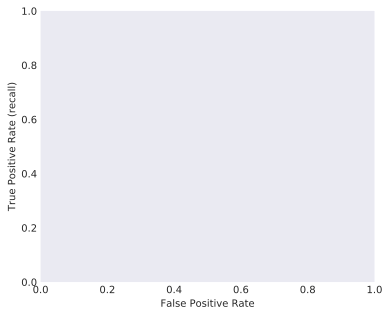

In [27]:
rcParams['figure.figsize'] = 8, 5
plt.figure(figsize=(6,5))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (recall)")
fpr9, tpr9, _= roc_curve(y_test, rfecv.predict_proba(X_test)[:, 1] )
auc9 = roc_auc_score(y_test, rfecv.predict_proba(X_test)[:, 1])
plt.plot(fpr9, tpr9, label=("auc=%.4f" % auc9), linewidth=2,
color='#990000')
plt.legend(loc="best")

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
degrees = [1, 4, 15]
polynomial_features = PolynomialFeatures(degree=3, interaction_only=True,
                                             include_bias=False)
pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("rfecv", rfecv)])
train_poly = train_with_new_feature1.copy()
#polynomial_features.fit(train_poly, y)
#train_poly = polynomial_features.transform(train_poly)
pipeline.fit(train_poly, y)

print('2')


NameError: name 'train_with_new_feature1' is not defined

In [29]:
rfecv.ranking_
# array([1, 1, 1, 5, 7, 1, 1, 5, 1, 4, 1, 1, 7, 1, 1, 2, 1, 2, 1, 1, 6, 1,
#        1, 1, 1, 1, 1, 1, 1, 7, 1, 1, 4, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
#        1, 1, 1, 1, 1, 1, 4, 5, 1, 1, 3, 4, 3, 1, 1, 1, 6, 3, 4, 4, 1, 2,
#        6, 1, 6, 1, 7, 3, 6, 5, 8, 6, 6, 2, 5, 2, 4, 1, 6, 1, 1, 1, 4, 6,
#        1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 4, 1, 1, 3, 1, 6, 4, 4, 1, 3, 5,
#        7, 5, 1, 5, 1, 2, 4, 7, 4, 5, 8, 4, 5, 5, 4, 3, 1, 1, 5, 7, 1, 5,
#        6, 1, 2, 1, 2, 7, 1, 1, 6, 1, 2, 4, 7, 4, 4, 5, 1, 1, 7, 5, 5, 5,
#        4, 2, 7, 7, 7, 6, 2, 5, 6, 1, 2, 5, 4, 2, 5, 2, 1, 1, 1, 1, 1, 1,
#        3, 1, 1, 1, 2, 1, 1, 1, 1, 1, 4, 7, 1, 1, 1, 1, 3, 3, 1, 1, 6, 4,
#        1, 7, 1, 3, 5, 1, 6, 1, 5, 7, 7, 4, 8, 8, 5, 6, 8, 5, 1, 1, 5, 1,
#        1, 1, 5, 7, 1, 1, 4, 1, 3, 2, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 3, 1,
#        3, 3, 1, 4, 7, 4, 1, 6, 1, 2, 4, 3, 1, 1, 8, 5, 6, 4, 1, 3, 1, 3,
#        4, 7, 1, 5, 6, 1, 4, 3, 3, 7, 1, 3, 6, 1, 8, 1, 7, 4, 4, 6, 1, 2,
#        8, 5, 5, 8, 1, 2, 7, 8, 7, 7, 2, 5, 6, 1, 2, 7, 3, 2, 6, 2, 2, 1,
#        1, 3, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 4, 1, 1, 2, 1, 1, 1, 1, 1,
#        7, 1, 2, 1, 1, 4, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 4, 1, 1, 2,
#        2, 2, 1, 1, 1, 2, 2, 1, 5, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 7, 1, 3,
#        1, 1, 1, 1, 1, 1, 2, 4, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1,
#        1, 1, 4, 1, 1, 1, 1, 1, 1, 8, 1, 1, 1, 1, 1, 7, 1, 1, 1, 1, 8, 1,
#        1, 1, 3, 1, 1, 8, 1, 8, 3, 7, 1, 4, 1, 1, 5, 5, 5, 7, 5, 6, 6, 5,
#        2, 1, 3, 8, 3, 3, 1, 8, 6, 4, 4, 7, 1, 3, 1, 1, 1, 1, 1, 1, 6, 3,
#        3, 1, 1, 4, 5, 4, 4, 3, 5, 7, 4, 3, 8, 3, 3, 5, 1, 4, 4, 8, 5, 6,
#        7, 4, 4, 3, 3, 8, 6, 3, 5, 8, 3, 3, 1, 1, 6, 3, 4, 5, 1, 7, 1, 6,
#        3, 4, 4, 1, 2, 7, 5, 6, 8, 1, 2, 6, 7, 8, 6, 4, 5, 8, 3, 2, 8, 4,
#        4, 4, 4, 1, 1, 5, 1, 5, 1, 7, 6, 6, 5, 6, 7, 8, 3, 1, 1, 4, 1, 1,
#        1, 1, 1, 5, 1, 1, 4, 7, 6, 1, 7, 7, 8, 6, 6, 5, 6, 2, 5, 1, 5, 1,
#        5, 5, 8, 1, 5, 3, 8, 6, 8, 8, 7, 6, 7, 7, 2, 7, 7, 6, 8, 6, 8, 7,
#        6, 5, 8, 6, 7, 7, 6, 2, 6, 7, 8, 5, 7, 5, 8, 8, 7, 8, 2, 6, 8, 7,
#        2, 8, 7, 2, 8, 2, 2, 3, 6, 1, 1, 1, 1, 1, 1, 3, 4, 1, 4, 5, 4, 3,
#        3, 7, 6, 5, 1, 5, 1, 3, 8, 1, 7, 6, 8, 8, 7, 5, 5, 3, 1, 1, 8, 7,
#        1, 5, 5, 1, 2, 1, 1, 7, 1, 4, 6, 1, 3, 7, 6, 4, 4, 8, 1, 4, 8, 7,
#        8, 8, 5, 2, 7, 7, 7, 6, 2, 5, 6, 1, 2, 8, 3, 2, 5, 2, 3, 1, 1, 3,
#        1, 3, 7, 4, 1, 3, 1, 3, 3, 1, 1, 1, 1, 3, 3, 3, 1, 4, 1, 1, 1, 5,
#        1, 3, 1, 1, 3, 1, 5, 1, 1, 3, 1, 2, 4, 1, 6, 1, 2, 5, 1, 3, 3, 3,
#        3, 1, 4, 3, 5, 5, 8, 6, 3, 4, 6, 1, 3, 3, 1, 2, 7, 3, 3, 6, 8, 6,
#        4, 8, 6, 4, 6, 6, 7, 6, 5, 6, 8, 4, 4, 8, 4, 3, 4, 6, 8, 6, 1, 6,
#        3, 2, 6, 7, 5, 3, 7, 1, 2, 8, 7, 5, 8, 6, 2, 8, 7, 8, 7, 2, 5, 8,
#        5, 3, 5, 1, 2, 7, 2, 2, 4, 5, 4, 7, 4, 6, 6, 4, 3, 1, 7, 6, 4, 8,
#        7, 1, 3, 4, 8, 5, 6, 6, 4, 3, 8, 4, 5, 5, 4, 3, 7, 8, 8, 8, 2, 7,
#        6, 4, 3, 6, 6, 2, 6, 3, 3, 4, 4, 7, 1, 6, 7, 1, 2, 5, 7, 1, 5, 7,
#        1, 2, 8, 5, 8, 8, 5, 2, 7, 8, 8, 7, 2, 5, 6, 1, 2, 8, 5, 2, 6, 2,
#        3, 1, 7, 5, 5, 6, 1, 4, 6, 5, 7, 7, 1, 3, 8, 8, 8, 7, 3, 6, 8, 1,
#        2, 8, 4, 2, 6, 4, 2, 7, 6, 6, 8, 4, 2, 7, 8, 8, 7, 2, 6, 7, 4, 1,
#        8, 4, 3, 5, 3, 1, 8, 8, 8, 8, 2, 8, 8, 5, 2, 8, 6, 3, 7, 6, 2, 8,
#        8, 7, 2, 8, 8, 2, 8, 3, 2, 8, 5, 2, 6, 2, 1, 8, 2, 2, 2])

AttributeError: 'RFECV' object has no attribute 'ranking_'

NameError: name 'train_poly' is not defined

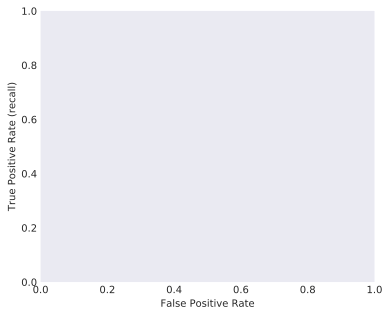

In [30]:
rcParams['figure.figsize'] = 8, 5
plt.figure(figsize=(6,5))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (recall)")
#fpr9, tpr9, _= roc_curve(y_train, pipeline.predict_proba(X_train)[:, 1] )
auc9 = roc_auc_score(y, pipeline.predict_proba(train_poly)[:, 1])
#plt.plot(fpr9, tpr9, label=("auc=%.4f" % auc9), linewidth=2, color='#990000')
#plt.legend(loc="best")
#auc=0.8660 // degree - 3, 2, interaction = True
print("auc=%.4f" % auc9)

In [31]:
test_with_new_features =  test.copy()
test_log_reg_data = test_with_new_features.copy()
##большие значения у линий - выбросы, уберем их



test_log_reg_data['линии'][(test_log_reg_data['линии'] >= 10)] = 0.3
test_log_reg_data['доход'][test_log_reg_data['доход'] > test_log_reg_data['доход'].quantile(q=0.85)] = test_log_reg_data['доход'].quantile(q=0.4)
test_log_reg_data['Debt_Ratio'][test_log_reg_data['Debt_Ratio'] > test_log_reg_data['Debt_Ratio'].quantile(q=0.8)] = test_log_reg_data['Debt_Ratio'].quantile(q=0.4)

feature_1 = (test_log_reg_data['поведение_30-59_дней'] >= 1) #| (test_log_reg_data['поведение_60-89_дней'] >= 1) \
            # | (test_log_reg_data['поведение_90_дней'] >= 1)
test_log_reg_data['feature_1'] = feature_1
test_log_reg_data['поведение_90_дней'][test_log_reg_data['поведение_90_дней'] > 35] = 1
test_log_reg_data['поведение_60-89_дней'][test_log_reg_data['поведение_60-89_дней'] > 35] = 1
test_log_reg_data['поведение_30-59_дней'][test_log_reg_data['поведение_30-59_дней'] > 35] = 1




feature_2 = (test_log_reg_data['недвижимость'] >= 1) 
test_log_reg_data['feature_2'] = feature_2

# feature_3 = (test_log_reg_data['число_кредитов'] >= 15)
# test_log_reg_data['feature_3'] = feature_3

# feature_4 = (test_log_reg_data['доход'] <= test_log_reg_data['доход'].quantile(q=0.35))
# test_log_reg_data['feature_4'] = feature_4

# feature_5 = (test_log_reg_data['Debt_Ratio'] <= test_log_reg_data['Debt_Ratio'].mean()))
# test_log_reg_data['feature_5'] = feature_5

feature_6 = (test_log_reg_data['линии'] <= test_log_reg_data['линии'].quantile(q=0.05))
test_log_reg_data['feature_6'] = feature_6

feature_7 = (test_log_reg_data['поведение_60-89_дней'] >= 1)
test_log_reg_data['feature_7'] = feature_7

feature_8 = (test_log_reg_data['поведение_90_дней'] >= 1)
test_log_reg_data['feature_8'] = feature_8

feature_9 = (test_log_reg_data['возраст'] >= test_log_reg_data['возраст'].quantile(q=0.6))
test_log_reg_data['feature_9'] = feature_9

feature_10 = (3*test_log_reg_data['поведение_60-89_дней'] + 5 * test_log_reg_data['поведение_30-59_дней']) > test_log_reg_data['поведение_90_дней']
test_log_reg_data['feature_10'] = feature_10

# feature_11 = np.log2(test_log_reg_data['линии']+ 0.00001)
# test_log_reg_data['feature_11'] = feature_11



# test_log_reg_data.pop('поведение_30-59_дней')
# test_log_reg_data.pop('поведение_60-89_дней')
# test_log_reg_data.pop('поведение_90_дней')
# test_log_reg_data['feature_1'][test_log_reg_data['feature_1'] == True] = 1
# test_log_reg_data['feature_1'][test_log_reg_data['feature_1'] == False] = 0
# test_log_reg_data['feature_2'][test_log_reg_data['feature_2'] == True] = 1
# test_log_reg_data['feature_2'][test_log_reg_data['feature_2'] == False] = 0
# test_log_reg_data['feature_3'][test_log_reg_data['feature_3'] == True] = 1
# test_log_reg_data['feature_3'][test_log_reg_data['feature_3'] == False] = 0
# test_log_reg_data['feature_4'][test_log_reg_data['feature_4'] == True] = 1
# test_log_reg_data['feature_4'][test_log_reg_data['feature_4'] == False] = 0
# test_log_reg_data['feature_5'][test_log_reg_data['feature_5'] == True] = 1
# test_log_reg_data['feature_5'][test_log_reg_data['feature_5'] == False] = 0
# 
# test_log_reg_data['feature_1'] = test_log_reg_data['feature_1'].astype(bool)
# test_log_reg_data['feature_2'] = test_log_reg_data['feature_2'].astype(bool)
# test_log_reg_data['feature_3'] = test_log_reg_data['feature_3'].astype(bool)
test_log_reg_data['семья'] = test_log_reg_data['семья'].astype(int)


col_names = ['линии', 'доход', 'Debt_Ratio']
features = test_log_reg_data[col_names]
features = StandardScaler().fit_transform(features)
test_log_reg_data[col_names] = features

test_with_new_feature1 = test_log_reg_data.copy()
new_feature = np.log(test['линии']+0.000001) + test['возраст'] + \
    test['поведение_30-59_дней'] + test['поведение_60-89_дней'] + \
    test['поведение_90_дней'] + test['доход'] + test['Debt_Ratio'] + \
    test['семья']
test_with_new_feature1['feature_new'] = new_feature
# test_with_new_feature1.pop('линии')
# test_with_new_feature1.pop('доход')
# test_with_new_feature1.pop('Debt_Ratio')
# test_with_new_feature1.pop('поведение_30-59_дней')
# test_with_new_feature1.pop('поведение_60-89_дней')
# test_with_new_feature1.pop('поведение_90_дней')
# test_with_new_feature1.pop('семья')
# test_with_new_feature1.pop('возраст')
# test_with_new_feature1.pop('число_кредитов')
# test_with_new_feature1.pop('недвижимость')



ValueError: Cannot convert non-finite values (NA or inf) to integer

In [ ]:
model_logreg_pipeline_prediction = pipeline.predict_proba(test_with_new_feature1)[:, 1]
pd.DataFrame({'id' : np.arange(37500), 'a' : model_logreg_pipeline_prediction}).to_csv('/home/paniquex/PycharmProjects/IML_homeworks/credit_scoring/solution_logistic_reg_pipeline_polynomial_3degrees_with_new_features.csv', index=False)

In [32]:
test_with_new_feature1.info()

NameError: name 'test_with_new_feature1' is not defined

In [33]:
rand_forest_last = RandomForestClassifier(n_estimators=125, criterion= 'entropy', min_impurity_decrease=0.00001,
 min_weight_fraction_leaf = 0.00005,
 min_impurity_split = 0.00004,
 max_depth= 11,
 max_features= 3,
 #class_weight = 'balanced',
 min_samples_leaf= 29,
 min_samples_split= 159,
 oob_score= True,
 bootstrap=False,
 random_state = 20)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train, y, train_size = 0.8, random_state=20)

rand_forest_last.fit(X_train, y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

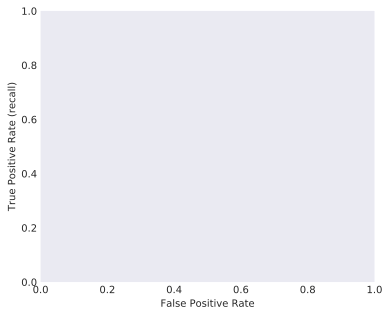

In [34]:
rcParams['figure.figsize'] = 8, 5
plt.figure(figsize=(6,5))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (recall)")
#fpr9, tpr9, _= roc_curve(y_train, pipeline.predict_proba(X_train)[:, 1] )
auc9 = roc_auc_score(y_test, rand_forest_last.predict_proba(X_test)[:, 1])
#plt.plot(fpr9, tpr9, label=("auc=%.4f" % auc9), linewidth=2, color='#990000')
#plt.legend(loc="best")
#auc=0.8653 // 2, interaction = True
print("auc=%.4f" % auc9)
#auc=0.8689

In [35]:
model_logreg_pipeline_prediction = rand_forest_last.predict_proba(test)[:, 1]
pd.DataFrame({'id' : np.arange(37500), 'a' : model_logreg_pipeline_prediction}).to_csv('/home/paniquex/PycharmProjects/IML_homeworks/credit_scoring/solution_random_forest_with_grid_last.csv', index=False)

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

# Try to get mean of 3 best submissions

In [12]:
submission_1 = pd.read_csv('1.csv')
submission_2 = pd.read_csv('2.csv')
submission_3 = pd.read_csv('3.csv')

In [13]:
submission = submission_1.copy()

In [14]:
submission['a'] = (submission_1['a'] + submission_2['a'] + submission_3['a']) / 3

In [17]:
submission['a'] - submission_1['a']

0       -0.025998
1       -0.001178
2       -0.002870
3       -0.001808
4       -0.000650
5       -0.000713
6       -0.022765
7       -0.008043
8        0.002077
9       -0.000260
10      -0.005501
11       0.000040
12      -0.019755
13      -0.000351
14      -0.000668
15      -0.001052
16      -0.000079
17      -0.000239
18      -0.000169
19      -0.009129
20      -0.000709
21      -0.001757
22      -0.008803
23      -0.001148
24      -0.000923
25      -0.000656
26      -0.000339
27      -0.000979
28       0.002656
29      -0.003854
           ...   
37470   -0.000825
37471    0.002320
37472   -0.010528
37473   -0.025036
37474    0.002266
37475   -0.003551
37476   -0.000460
37477   -0.001643
37478    0.001006
37479   -0.000106
37480   -0.000290
37481   -0.001531
37482   -0.001091
37483    0.001983
37484   -0.000168
37485   -0.000615
37486    0.002085
37487    0.004285
37488   -0.009166
37489   -0.009662
37490   -0.013239
37491    0.001923
37492    0.001886
37493    0.000227
37494    0

In [16]:
pd.DataFrame({'id' : np.arange(37500), 'a' : submission['a']}).to_csv('/home/paniquex/PycharmProjects/IML_homeworks/credit_scoring/mean_of_3_best_submissions.csv', index=False)

# Try to make Partial Dependence plots

,линии,возраст,поведение_30-59_дней,Debt_Ratio,доход,число_кредитов,поведение_90_дней,недвижимость,поведение_60-89_дней,семья
0,0.031258,57,0,0.397520,5000.0,15,0,2,0,0.0
1,0.052332,64,0,57.000000,NaN,2,0,0,0,NaN
2,1.051793,40,1,444.000000,NaN,2,1,0,0,0.0
3,0.981993,40,1,0.780109,6625.0,8,0,1,0,4.0
4,0.163684,67,0,0.317596,4574.0,5,0,2,0,0.0


In [86]:
from sklearn.preprocessing import Imputer
train_without_missing = train.copy()
imputer = Imputer()
train_without_missing = imputer.fit_transform(train_without_missing)
assiveAggre_best.fit(train_without_missing, y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.099, loss='deviance', max_depth=4,
              max_features=4, max_leaf_nodes=None,
              min_impurity_decrease=1e-05, min_impurity_split=4e-05,
              min_samples_leaf=160, min_samples_split=760,
              min_weight_fraction_leaf=5e-05, n_estimators=350,
              n_iter_no_change=None, presort='auto', random_state=20,
              subsample=0.7, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

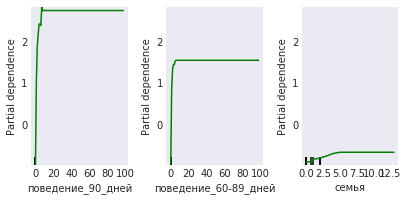

In [91]:
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
my_plots = plot_partial_dependence(
                                  features=[6, 8, 9],
                                  X=train_without_missing,
                                  feature_names=list(train_log_reg_data.columns),
                                  grid_resolution=20,
                                  gbrt=assiveAggre_best,
                                  n_cols=6)

In [75]:
plot_partial_dependence?